In [1]:
%load_ext autoreload

In [2]:
import math
import numpy as np

import torch
from torch import nn
from torch import distributions

import numpy as np
import random

from IPython.display import clear_output
import matplotlib.pyplot as plt

from tqdm.auto import trange

In [3]:
%autoreload 2
from model import SimpleNet, ModelOutput, Energy
from samplers import losses
from buffers import ReplayBuffer
from datasets_2d import DatasetSampler
from ema import EMA

In [4]:
def seed_everything(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

In [ ]:
def extract_into_tensor(tensor, shape):
    num_expand_dims = len(shape) - 1
    return tensor.view([-1] + [1 for _ in range(num_expand_dims)])


def rotate_mean(mean, angle=torch.pi / 4):
    cos = math.cos(angle)
    sin = math.sin(angle)
    R = torch.tensor([
        [cos, -sin],
        [sin,  cos]
    ], device=mean.device)
    return (R @ mean.T).T


def scatter(tensor, alpha=1.0):
    plt.scatter(tensor[:, 0], tensor[:, 1], alpha=alpha)
    

def plot_trajectory(trajectory, labels: list[str] | None = None, 
                    indices: None | list = None, title: str | None = None, 
                    xlim=(-1.5, 1.5), ylim=(-1.5, 1.5)):
    if indices is not None:
        trajectory = [trajectory[i] for i in indices]
        if labels is not None:
            labels = [labels[i] for i in indices]

    figure, axes  = plt.subplots(1, len(trajectory), figsize=(4 * len(trajectory), 4))
    if title is not None:
        figure.suptitle(title)
    
    for i, sample in enumerate(trajectory):
        title = labels[i] if labels is not None else f'iter {i}'
        
        axes[i].set_title(title)
        axes[i].scatter(sample[:, 0], sample[:, 1]) 
        axes[i].set_xlim(*xlim)
        axes[i].set_ylim(*ylim)
    
    return figure

@torch.no_grad()
def draw_level_lines(func, samples=None, lims=(-2, 2), nsamples: int = 100):
    x = np.linspace(*lims, nsamples)  # Define x-axis range
    y = np.linspace(*lims, nsamples)  # Define y-axis range
    X, Y = np.meshgrid(x, y)     # Create grid of points

    grid_points = np.stack([X, Y], axis=-1)  # Shape: [100, 100, 2]

    grid_points = torch.from_numpy(grid_points).reshape(-1, 2).float()
    Z = func(grid_points).numpy()  # Shape: [100, 100]
    Z = Z.reshape(nsamples, nsamples).T

    plt.figure()
    contour = plt.contour(X, Y, Z, levels=7, colors='k')  # Draw contour lines
    plt.clabel(contour, inline=True, fontsize=6)           # Add labels to contours
    plt.contourf(X, Y, Z, levels=10, cmap='viridis', alpha=0.5)    
    if samples is not None:
        plt.scatter(samples[:, 0], samples[:, 1], c='r')
    plt.colorbar(label='Function Value')                  # Add color bar
    plt.title('Level Lines of the Function')
    plt.xlabel('X-axis')
    plt.ylabel('Y-axis')
    plt.show()


def get_drid(lims=(-5, 5), nsamples=100):
    x = np.linspace(*lims, nsamples)  # Define x-axis range
    y = np.linspace(*lims, nsamples)  # Define y-axis range
    X, Y = np.meshgrid(x, y)     # Create grid of points

    grid_points = np.stack([X, Y], axis=-1)
    return torch.from_numpy(grid_points).reshape(-1, 2).float()

In [6]:
alpha = 4.0
gamma = 0.012
t_max = 0.024
n_steps = 20


def ref_process(x, t):
    return ModelOutput(drift=alpha * x)


def get_mean_log_var(model, x, t, dt):
    log_var = torch.as_tensor(2.0 * dt, device=x.device).log()
    output = model(x, t)
    
    if output.contains('log_var'):
        log_var = log_var + output.log_var
    
    mean = x + output.drift * dt
    return mean, log_var


def make_euler_maruyama_step(model, x, t, dt):
    mean, log_var = get_mean_log_var(model, x, t, dt)
    return mean + torch.randn_like(mean) * log_var.exp().sqrt()


def log_normal_density(x, mean, log_var):
    return - 0.5 * (log_var + torch.exp(- log_var) * (x - mean).pow(2)).sum(-1)


def sample_trajectory(model, x_start, direction, dt, n_steps, t_max, 
                      only_last: bool = False, return_timesteps: bool = False):
    assert direction in {"forward", "backward"}
    trajectory, timesteps = [x_start], [f"timestep {t_max if direction == 'backward' else 0}"]
    
    for t_step in (
            torch.linspace(dt, t_max, n_steps).flip(-1) \
            if direction == 'backward' \
            else torch.linspace(0, t_max - dt, n_steps)
        ):
        shift = - dt if direction == "backward" else + dt
        timesteps.append(f"timestep {t_step.item() + shift:.3f}")
        
        t = torch.ones(x_start.size(0)) * t_step
        trajectory.append(make_euler_maruyama_step(model, trajectory[-1], t, dt))
    
    if return_timesteps:
        return trajectory, timesteps
    
    if only_last:
        return trajectory[-1]
    
    return trajectory

In [7]:
class GaussMix:
    def __init__(self, means, sigmas):
        mix = distributions.Categorical(torch.ones(means.size(0), device=means.device))
        comp = distributions.Independent(distributions.Normal(means, sigmas), 1)
        self.gmm = distributions.MixtureSameFamily(mix, comp)

        self._grad = torch.func.grad(lambda y: self.log_prob(y).sum())

    def sample(self, n_samples):
        return self.gmm.sample((n_samples,))

    def to(self, device='cpu'):
        self.gmm.to(device)

    def log_prob(self, x):
        return self.gmm.log_prob(x)
    
    def grad(self, x):
        return self._grad(x)

In [8]:
def add_uniform_circular_noise(size, max_radius, device='cpu'):
    radius = torch.rand(size, device=device) * max_radius
    angle = torch.rand(size, device=device) * 2 * math.pi
    return torch.stack([torch.cos(angle), torch.sin(angle)], dim=-1) * radius.view(-1, 1)

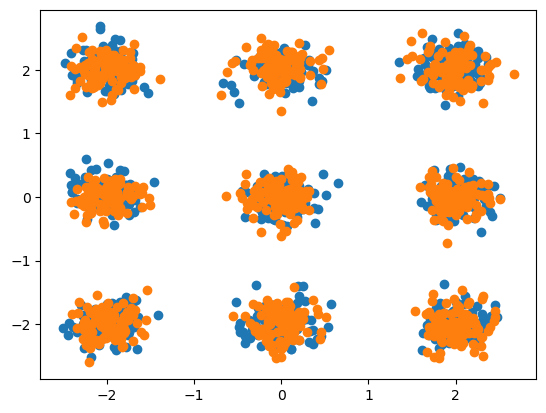

In [9]:
grid = torch.arange(3) - 1

means = torch.cat([
    grid.view(-1, 1).repeat(1, 3).view(3, 3, 1), 
    grid.view(1, -1).repeat(3, 1).view(3, 3, 1)], 
dim=-1).reshape(9, 2) * 2.0
sigmas = torch.ones_like(means) * 0.2

log_p_1 = GaussMix(means, sigmas)
logp_enegy = lambda x: - log_p_1.log_prob(x)

sampler = DatasetSampler(
    p_0='mix_of_gaussians', p_0_args=[means, sigmas],
    p_1='mix_of_gaussians', p_1_args=[means, sigmas],
)

x_0, x_1 = sampler.sample(900)

scatter(x_0)
scatter(x_1)

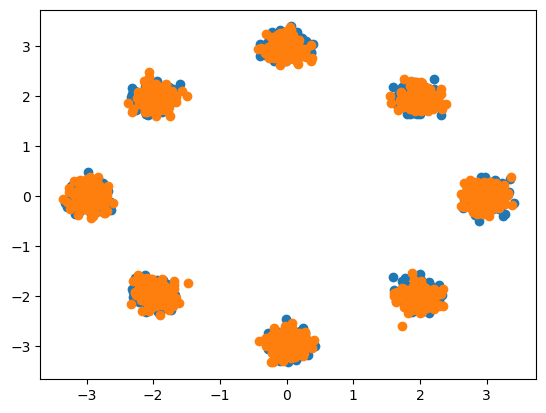

In [10]:
means2 = torch.tensor([[-2, 2], [2, 2],
                       [-3, 0], [3, 0],
                       [0, -3], [0, 3],
                       [-2, -2], [2, -2]]
                       ).float() * 0.99

sigmas2 = torch.ones_like(means2) * 0.15

log_p_1 = GaussMix(means2, sigmas2)
true_energy_fn = lambda x: - log_p_1.log_prob(x)

sampler = DatasetSampler(
    p_0='mix_of_gaussians', p_0_args=[means2, sigmas2],
    p_1='mix_of_gaussians', p_1_args=[means2, sigmas2],
)

x_0, x_1 = sampler.sample(128 * 9)

scatter(x_0)
scatter(x_1)

True 0.12


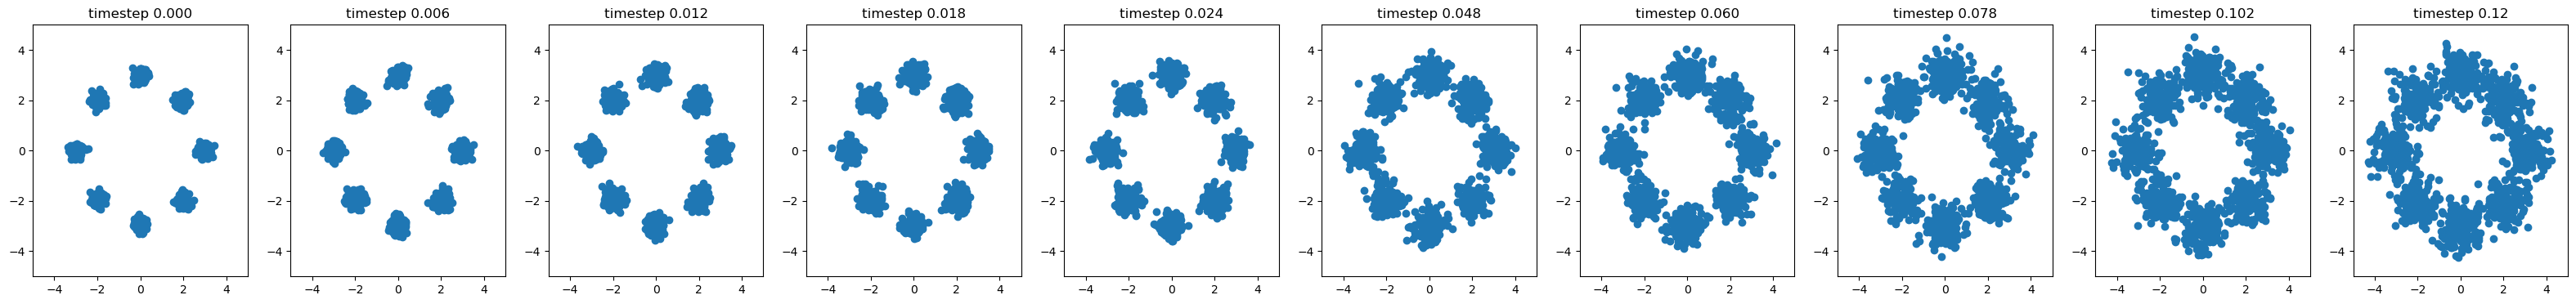

In [11]:
alpha = 0.24
gamma = 0.006
t_max = 0.12
n_steps = 20

print(gamma * n_steps == t_max, gamma * n_steps)

x_0, _ = sampler.sample(128 * 9)
trajectory, timesteps = sample_trajectory(ref_process, x_0, 'backward', gamma, 
                                          n_steps, t_max, return_timesteps=True)

_ = plot_trajectory(trajectory, timesteps[::-1], 
                    indices=[0, 1, 2, 3, 4, 8, 10, -8, -4, -1],
                    xlim=(-5, 5), ylim=(-5, 5))

In [14]:
N_TRAJECTORIES = 2
BATCH_SIZE = 512
BIG_X_0_SIZE = 512 * 9
N_SB_STEPS = 10_000


energy = Energy(2, 1, 128, 2, 
                use_ln=False, 
                block_type='simple')
energy_ema = EMA(energy, decay=0.999)

fwd_model = SimpleNet(64, in_dim=3, 
                      t_emb_size=None,
                      n_main_body_layers=1, 
                      predict_log_var=True)

bwd_model = SimpleNet(64, in_dim=3, 
                      t_emb_size=None,
                      n_main_body_layers=1, 
                      predict_log_var=True)


energy_optim = torch.optim.Adam(energy.parameters(), lr=2e-4)
fwd_optim = torch.optim.Adam(fwd_model.parameters(), lr=2e-4)
bwd_optim = torch.optim.Adam(bwd_model.parameters(), lr=1e-3)

energy_lr_scheduler = torch.optim.lr_scheduler.StepLR(
    energy_optim, step_size=2000, gamma=0.1
)

BIG_X_0, _ = sampler.sample(1024)

p1_buffer = ReplayBuffer(2048)

Iter=2700, backward Loss: -118.77174377441406,  backward lr 0.001


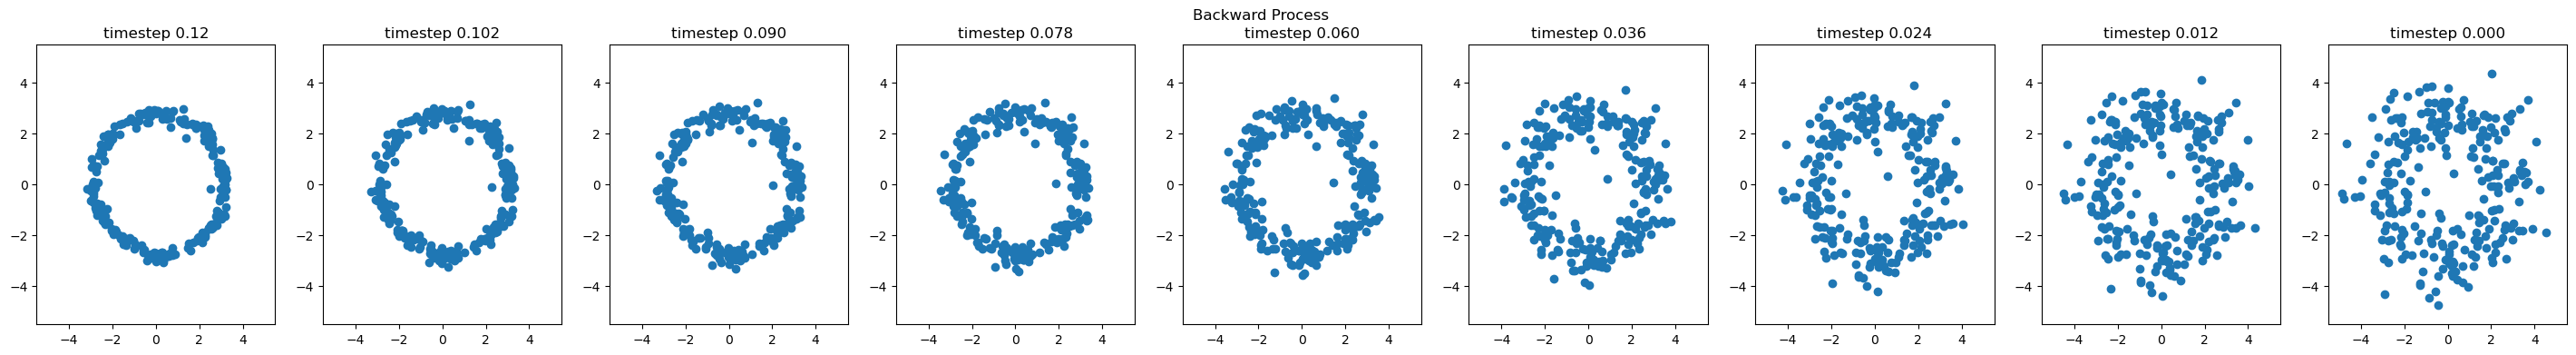

Iter=2700, Forward Loss: 11.581482887268066,  forward lr 8e-05


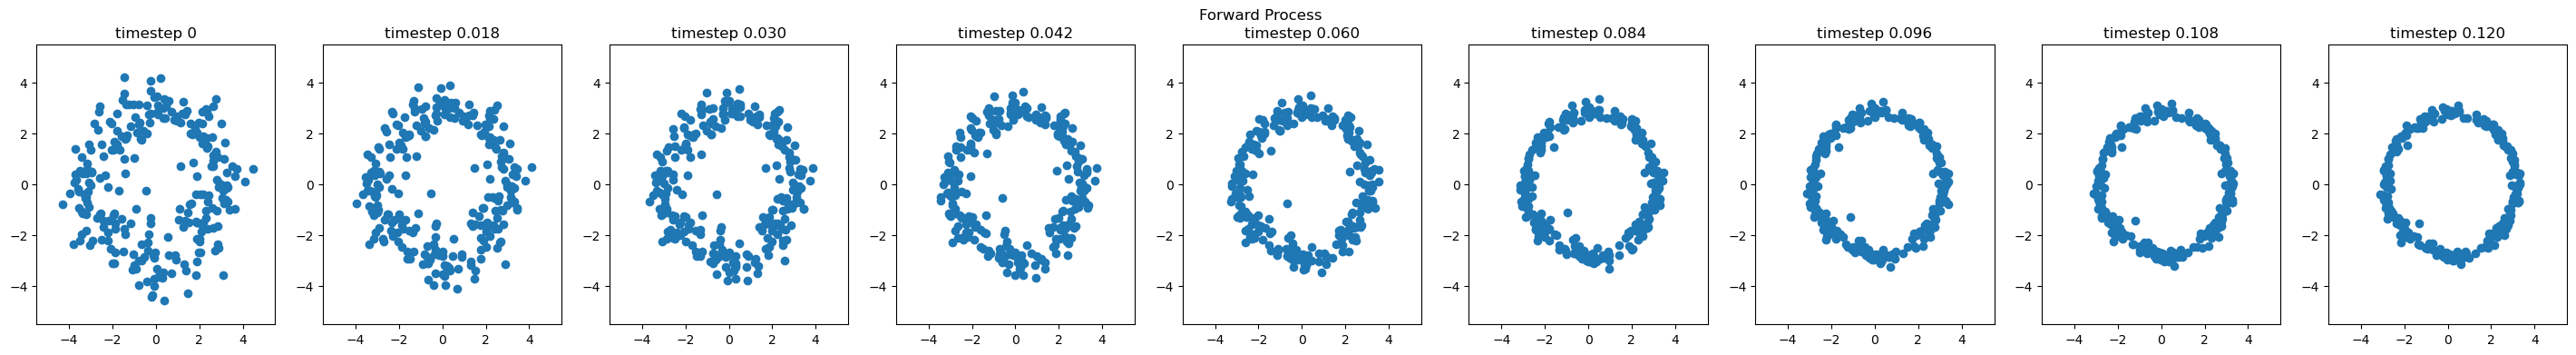

Iter=2700, Energy Loss: -0.40825653076171875,  energy lr 8e-05


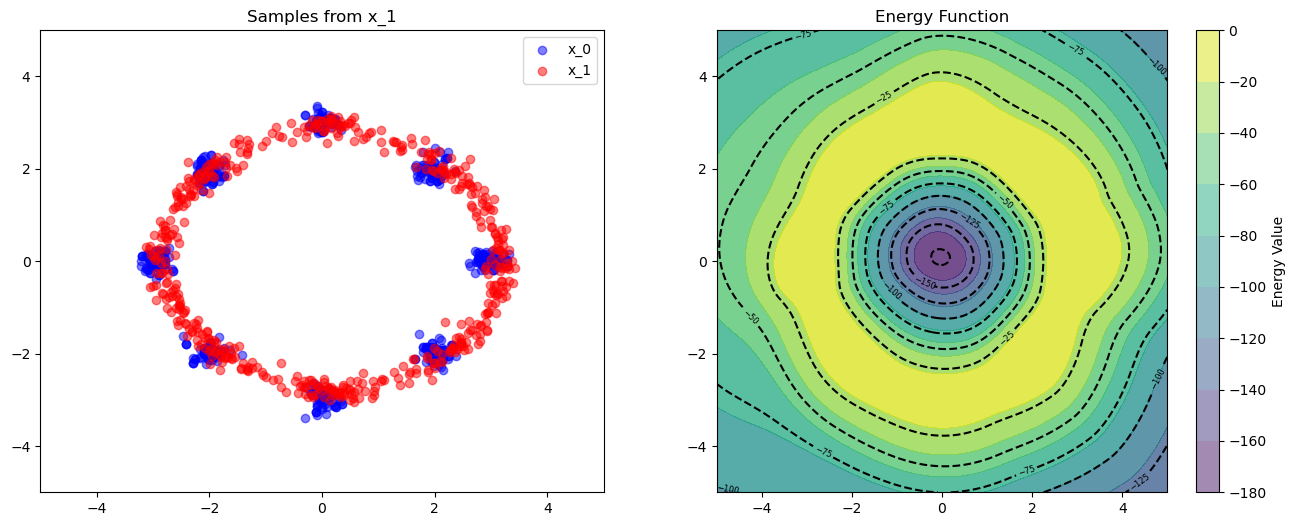

tensor([[-6.3890, -6.6487],
        [-6.7643, -6.8910],
        [-6.3707, -7.2502],
        ...,
        [-6.8451, -6.9821],
        [-6.6521, -7.4941],
        [-6.6522, -6.8702]])


AssertionError: log_var is NaN

In [16]:
seed_everything(3752)
logging_frequency = 100
noise_std = 0.7

energy_optim.param_groups[0]['lr'] = 8e-5
fwd_optim.param_groups[0]['lr'] = 8e-5
bwd_optim.param_groups[0]['lr'] = 1e-3


for it in range(20_000):
    num_bwd_iters = 1
    num_fwd_iters = 5
    num_energy_iters = 1
    # indices = torch.randperm(512 * 9)[:BATCH_SIZE]
    indices = torch.randint(0, BIG_X_0.size(0), (BATCH_SIZE,))
    
    
    # TRAIN BACKWARD PROCESS
    for _ in range(num_bwd_iters):
        bwd_optim.zero_grad(set_to_none=True)

        # x_0, _ = sampler.sample(BATCH_SIZE)
        
        x_0 = BIG_X_0[indices]
        x_0 = x_0 + torch.randn_like(x_0) * noise_std

        _fwd_model = ref_process if it == 0 else fwd_model
        loss = losses.compute_bwd_tlm_loss(_fwd_model, bwd_model, x_0, 
                                                gamma, t_max, n_steps)
        assert not torch.isnan(loss).any(), "backward loss is NaN"
        
        bwd_optim.step()

    # LOG BACKWARD TRAJECTORY
    if it % logging_frequency == 0:
        clear_output(wait=True)
        print(
            f'Iter={it}, backward Loss: {loss.item()},', 
            f" backward lr {bwd_optim.param_groups[0]['lr']}"
        )
        with torch.no_grad():
            x_0, _ = sampler.sample(BATCH_SIZE // N_TRAJECTORIES)
            x_0 = x_0 + torch.randn_like(x_0) * noise_std
            
            _fwd_model = ref_process if it == 0 else fwd_model
            fwd_trajectory, timesteps = sample_trajectory(
                _fwd_model, x_0, "forward", gamma, 
                n_steps, t_max, return_timesteps=True
            )
            bwd_trajectory, timesteps = sample_trajectory(
                bwd_model, fwd_trajectory[-1], "backward", 
                gamma, n_steps, t_max, return_timesteps=True
            )
        
        fig_bwd = plot_trajectory(bwd_trajectory, timesteps, 
                                  indices=[0, 3, 5, 7, 10, -7, -5, -3, -1],
                                  title="Backward Process" ,
                                  xlim=(-5.5, 5.5), ylim=(-5.5, 5.5))
        plt.show()

    # TRAIN FORWARD PROCESS
    for _ in range(num_fwd_iters):
        fwd_optim.zero_grad(set_to_none=True)

        x_0 = BIG_X_0[indices]
        bs = x_0.size(0)

        with torch.no_grad():
            x_0[:bs//2] = sample_trajectory(
                bwd_model, x_0[:bs//2], "backward", 
                gamma, n_steps, t_max, only_last=True
            )
            if not p1_buffer.is_empty():
                x_0[-bs//4:] = p1_buffer.sample(bs//4)
        
        x_0 = x_0.repeat(N_TRAJECTORIES, 1)
        x_0 = x_0 + torch.randn_like(x_0) * noise_std
        loss = losses.compute_fwd_vargrad_loss(fwd_model, bwd_model, 
                                               lambda x: - energy(x),
                                               x_0, gamma, t_max, n_steps, 
                                               p1_buffer=p1_buffer,
                                               n_trajectories=N_TRAJECTORIES,
                                               clip_loss=True)
        assert not torch.isnan(loss).any(), "forward loss is NaN"

        loss.backward()
        fwd_optim.step()

    # LOG FORWARD TRAJECTORY
    if it % logging_frequency == 0:
        print(
            f'Iter={it}, Forward Loss: {loss.item()},', 
            f" forward lr {fwd_optim.param_groups[0]['lr']}"
        )
        with torch.no_grad():
            x_0, _ = sampler.sample(BATCH_SIZE // N_TRAJECTORIES)
            x_0 = x_0 + torch.randn_like(x_0) * noise_std
            fwd_trajectory, timesteps = sample_trajectory(
                fwd_model, x_0, "forward", gamma, 
                n_steps, t_max, return_timesteps=True
            )
        
        fig_fwd = plot_trajectory(
            fwd_trajectory, timesteps, 
            indices=[0, 3, 5, 7, 10, -7, -5, -3, -1], 
            title="Forward Process", xlim=(-5.5, 5.5), ylim=(-5.5, 5.5)
        )
        plt.show()

    # TRAIN ENERGY FUNCTION
    pbar = trange(
        num_energy_iters, 
        leave=False, 
        desc=f'It {it} | Energy'
    ) if num_energy_iters > 10 else range(num_energy_iters)
    for i in pbar:
        with torch.no_grad():
            # indices = torch.randperm(1024)[:BATCH_SIZE // N_TRAJECTORIES]
            x_0 = BIG_X_0[indices]
            x_00 = x_0 #+ torch.randn_like(x_0) * noise_std

            x_1 = sample_trajectory(fwd_model, x_00, "forward", gamma, 
                                    n_steps, t_max, only_last=True)
        
        energy_optim.zero_grad(set_to_none=True)
        loss = losses.ebm_loss(energy, x_0, x_1, alpha=0.0)
        
        assert not torch.isnan(loss).any(), "energy loss is NaN"
        loss.backward()
        energy_optim.step()
        energy_ema.update()

    # energy_lr_scheduler.step()
    
    # LOG ENERGY FUNCTION
    limits = (-5, 5)
    if it % logging_frequency == 0:
        energy_ema.apply_shadow()
        print(
            f'Iter={it}, Energy Loss: {loss.item()},', 
            f" energy lr {energy_optim.param_groups[0]['lr']}"
        )
        fig, axes = plt.subplots(1, 2, figsize=(16, 6))

        # Scatter plot of samples from x_1
        with torch.no_grad():
            indices = torch.randint(0, BIG_X_0.size(0), (BATCH_SIZE,))
            x_0_log = BIG_X_0[indices] 
            x_0_log_noisy = x_0_log + torch.randn_like(x_0_log) * noise_std

            x_1_log = sample_trajectory(fwd_model, x_0_log_noisy, "forward", gamma, 
                                    n_steps, t_max, only_last=True)
            
        axes[0].scatter(x_0_log[:, 0], x_0_log[:, 1], c='b', alpha=0.5, label='x_0')
        axes[0].scatter(x_1_log[:, 0], x_1_log[:, 1], c='r', alpha=0.5, label='x_1')
        axes[0].legend()
        axes[0].set_title('Samples from x_1')
        axes[0].set_xlim(*limits)
        axes[0].set_ylim(*limits)

        # Energy function plot
        x = np.linspace(*limits, 200)
        y = np.linspace(*limits, 200)
        X, Y = np.meshgrid(x, y)
        grid_points = np.stack([X, Y], axis=-1)
        grid_points = torch.from_numpy(grid_points).reshape(-1, 2).float()
        log_density = - energy(grid_points).detach()
        log_density = log_density - log_density.max() 

        Z = log_density.numpy().reshape(200, 200).T

        contour = axes[1].contour(X, Y, Z, levels=7, colors='k')
        axes[1].clabel(contour, inline=True, fontsize=6)
        axes[1].contourf(X, Y, Z, levels=10, cmap='viridis', alpha=0.5)
        axes[1].set_title('Energy Function')
        axes[1].set_xlim(*limits)
        axes[1].set_ylim(*limits)
        fig.colorbar(axes[1].contourf(X, Y, Z, levels=10, cmap='viridis', 
                                        alpha=0.5), ax=axes[1], label='Energy Value')

        plt.show()
        energy_ema.restore()

In [ ]:
# For a 4 gaussians
#   for 1200 iterations
#   energy_optim.param_groups[0]['lr'] = 1e-3
#   fwd_optim.param_groups[0]['lr'] = 1e-4
#   bwd_optim.param_groups[0]['lr'] = 1e-3

#   next 1200 iterations
#   energy_optim.param_groups[0]['lr'] = 1e-3
#   fwd_optim.param_groups[0]['lr'] = 1e-4
#   bwd_optim.param_groups[0]['lr'] = 1e-3
#   --------------------------------------



In [ ]:
# torch.save(energy.state_dict(), 'energy_9gaussians_grid_models_path.pth')

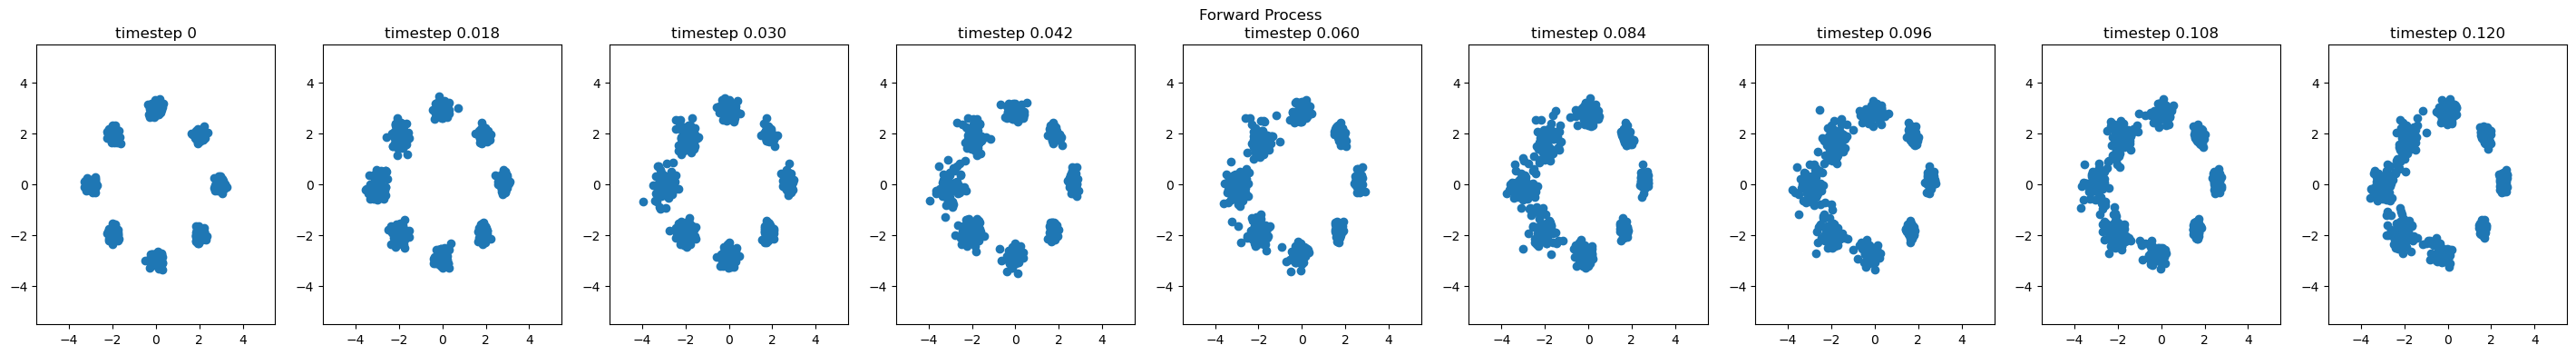

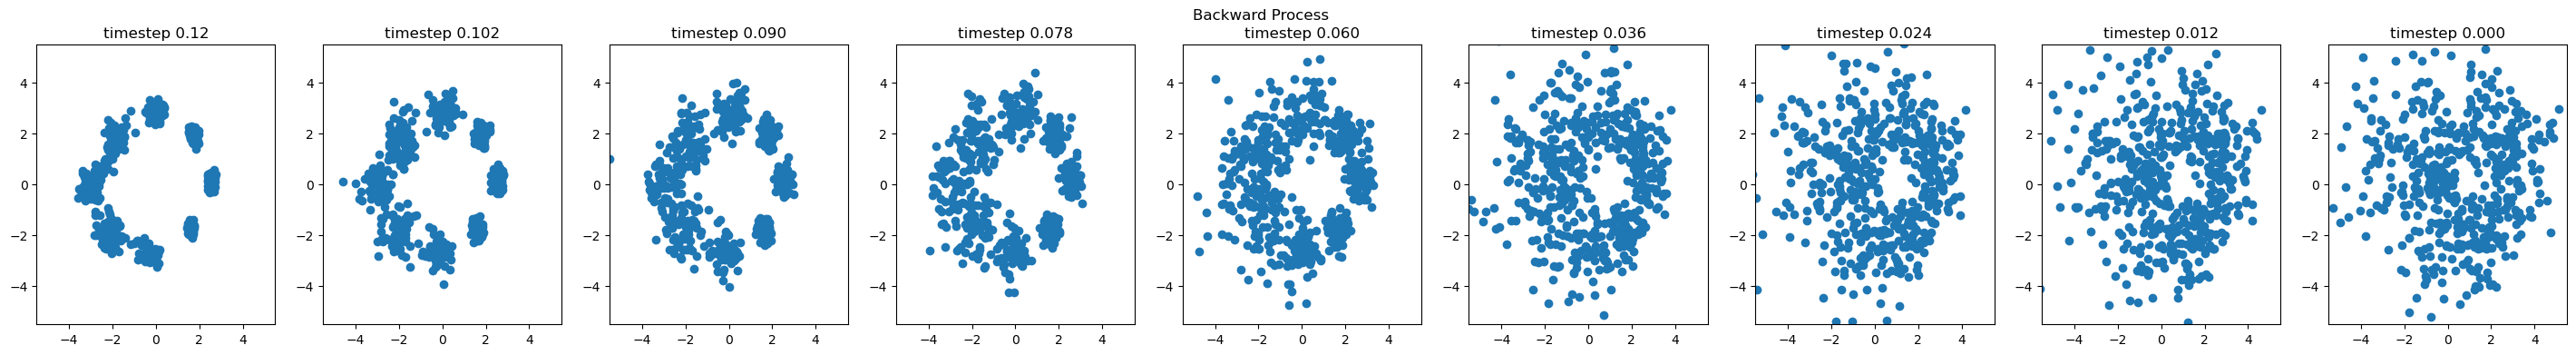

In [18]:
x_0, _ = sampler.sample(BATCH_SIZE)

with torch.no_grad():
    fwd_trajectory, timesteps = sample_trajectory(fwd_model, x_0, "forward", gamma, 
                                                  n_steps, t_max, return_timesteps=True)
_ = plot_trajectory(fwd_trajectory, timesteps, 
                    indices=[0, 3, 5, 7, 10, -7, -5, -3, -1], title="Forward Process",
                    xlim=(-5.5, 5.5), ylim=(-5.5, 5.5))

with torch.no_grad():
    bwd_trajectory, timesteps = sample_trajectory(bwd_model, fwd_trajectory[-1], "backward", gamma, 
                                                  n_steps, t_max, return_timesteps=True)
_ = plot_trajectory(bwd_trajectory, timesteps, 
                    indices=[0, 3, 5, 7, 10, -7, -5, -3, -1], title="Backward Process",
                    xlim=(-5.5, 5.5), ylim=(-5.5, 5.5))

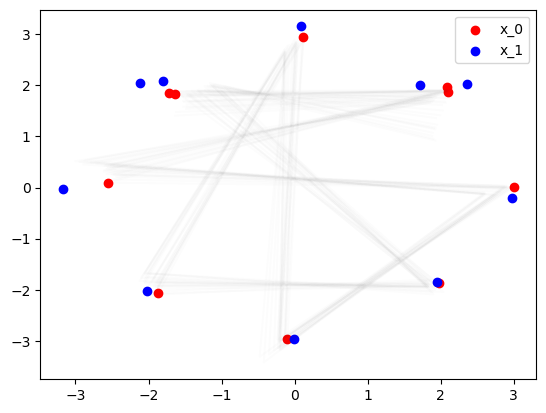

In [ ]:
n_points = 10
x_0 = fwd_trajectory[-1][:n_points]
x_1 = fwd_trajectory[0][:n_points]

for x_t in bwd_trajectory[1: -1]:
    plt.plot(x_t[:n_points, 0], x_t[:n_points, 1], c='black', alpha=0.01)

plt.scatter(x_0[:, 0], x_0[:, 1], c='red', label='x_0')
plt.scatter(x_1[:, 0], x_1[:, 1], c='blue', label='x_1')
plt.legend()

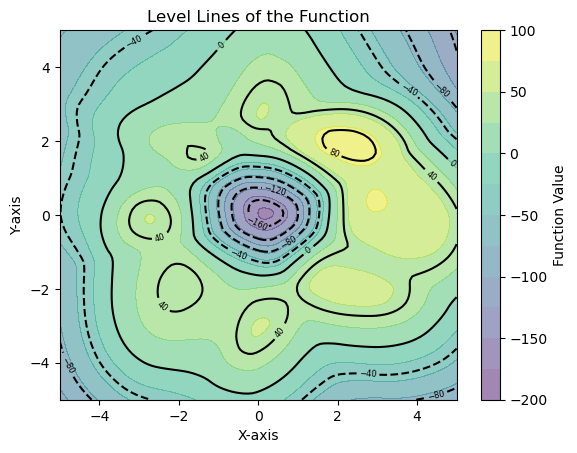

In [19]:
with torch.no_grad():
    draw_level_lines(lambda x: - energy(x), lims=(-5, 5))

Run langevin dynamics

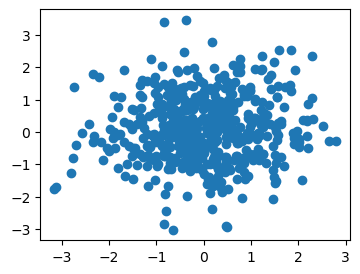

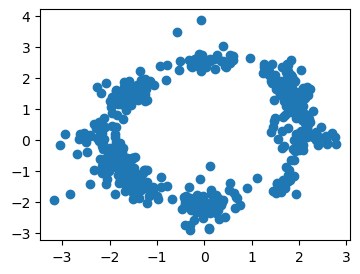

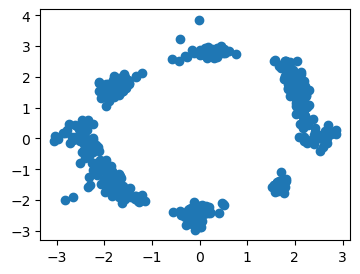

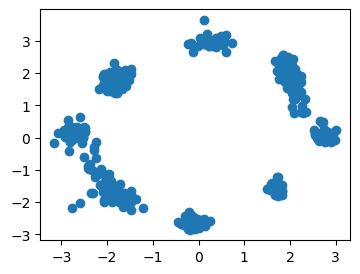

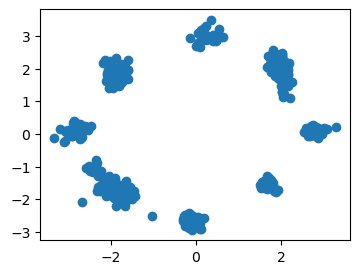

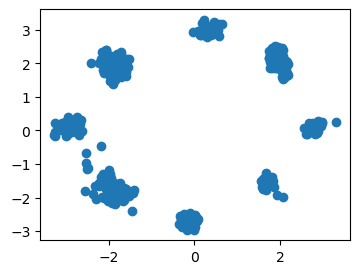

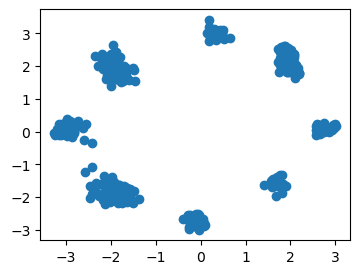

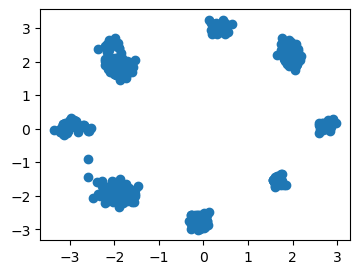

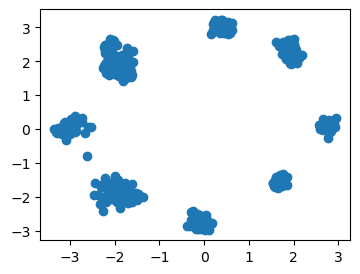

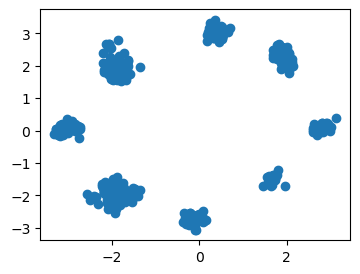

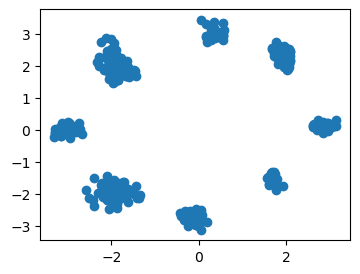

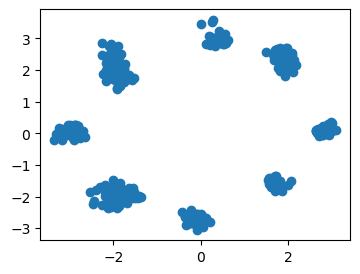

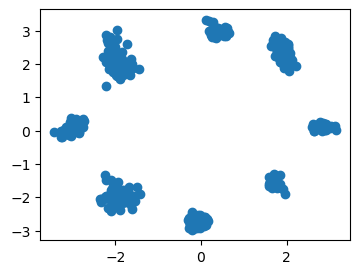

In [20]:
step_size = 0.0001
x = torch.zeros(512, 2)
x = torch.randn_like(x)


for i in range(3001):
    if i % 250 == 0:
        plt.figure(figsize=(4, 3))
        scatter(x.detach())
        plt.show()

    # if i > 1000:
    #     step_size = 0.00001
    
    _x = x.clone().detach().requires_grad_()
    grad = torch.autograd.grad(energy(_x).sum(), _x)[0]
    x = x - 0.5 * step_size * grad + torch.randn_like(x) * math.sqrt(step_size)
    
